In [6]:
# Import libraries
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder

pd.options.display.float_format = '{:20,.2f}'.format

# Import dataset
df = pd.read_csv('./Phishing_Email.csv')
df.drop(df.columns[0], axis=1, inplace=True)
df.dropna(inplace=True)

X = df.drop(columns=["Email Type"])
y = df["Email Type"]
texts_under, labels_under = RandomUnderSampler(random_state=100).fit_resample(X, y)

texts_under["Word Count"] = texts_under["Email Text"].apply(lambda texto: len(texto.split(" ")))

encoded_labels = LabelEncoder().fit_transform(labels_under)
encoded_labels

array([0, 0, 0, ..., 1, 1, 1])

In [7]:
import re

# Text cleaning function
def parse_sentence(text: str):
    clean_text = ""
    for word in text.lower().split(" "):
        if word.startswith('@') and len(word) > 1:
            word = 'user'
        elif word.startswith('http'):
            word = 'http'
        clean_text += word + " "
    clean_text = re.sub(r'["#$%&\'()*+,\-./:;<=>@[\]^_`{|}~―]', '', clean_text)
    clean_text = clean_text.replace('  ', ' ')
    return clean_text[:-1]

texts_clean = texts_under["Email Text"].apply(lambda texto: parse_sentence(texto))
texts_clean.values

array(['\nhello i am your hot lil horny toy\n  i am the one you dream about\n  i am a very open minded person\n  love to talk about and any subject\n  fantasy is my way of life \n  ultimate in sex play   ummmmmmmmmmmmmm\n   i am wet and ready for you   it is not your looks but your imagination that matters most\n   with my sexy voice i can make your dream come true\n \n   hurry up! call me let me cummmmm for you\ntollfree       1877451teen 18774518336for phone billing   19009932582\n \n\nsignup for your own free personalized email at mailcom\nhttpwwwmailcom?srsignup',
       'software at incredibly low prices 86 lower  drapery seventeen term represent any sing feet wild break able build tail send subtract represent job cow student inch gave let still warm family draw land book glass plan include sentence is hat silent nothing order wild famous long their inch such saw person save face especially sentence science certain cry does two depend yes written carry',
       'entourage stockmog

In [8]:
# Import necessary libraries
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
import numpy as np

# Load and preprocess data
class EmailDataset(Dataset):
    def __init__(self, emails, labels, tokenizer, max_len):
        self.emails = emails
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.emails)

    def __getitem__(self, index):
        email = self.emails[index]
        label = self.labels[index]

        encoding = self.tokenizer.encode_plus(
            email,
            truncation=True,
            padding='max_length',
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'email_text': email,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Step 4: Tokenizer and Dataset Preparation
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_token_length = 512

df = pd.DataFrame(data={
    "email": texts_clean.values,
    "label": encoded_labels
})

In [9]:
# Training
for seed in range(5):
    # Model Setup
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)

    # Split the dataset into train (70%), validation (15%), and test (15%)
    df_train, df_temp = train_test_split(df, test_size=0.3, random_state=seed)
    df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=seed)

    train_dataset = EmailDataset(
        emails=df_train.email.to_numpy(),
        labels=df_train.label.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_token_length
    )

    val_dataset = EmailDataset(
        emails=df_val.email.to_numpy(),
        labels=df_val.label.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_token_length
    )

    test_dataset = EmailDataset(
        emails=df_test.email.to_numpy(),
        labels=df_test.label.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_token_length
    )

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    print(f'Iteration: {seed}')
    num_epochs = 3
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    total_steps = len(train_loader) * num_epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        train_losses = []

        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss
            logits = outputs.logits
            _, preds = torch.max(logits, dim=1)
            train_losses.append(loss.item())
            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        train_loss = np.mean(train_losses)
        model.eval()
        val_losses = []

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )
                loss = outputs.loss
                logits = outputs.logits
                _, preds = torch.max(logits, dim=1)
                val_losses.append(loss.item())

        val_loss = np.mean(val_losses)
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # Save the best model
            torch.save(model.state_dict(), f'Models/best_BERT_model_{seed}.pt')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Iteration: 0


c:\Users\guimo\Downloads\PyTorch\env\Lib\site-packages\transformers\models\bert\modeling_bert.py:435: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Epoch 1/3, Train Loss: 0.1776, Val Loss: 0.0847
Epoch 2/3, Train Loss: 0.0501, Val Loss: 0.0705
Epoch 3/3, Train Loss: 0.0315, Val Loss: 0.0672


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Iteration: 1
Epoch 1/3, Train Loss: 0.1435, Val Loss: 0.0755
Epoch 2/3, Train Loss: 0.0408, Val Loss: 0.0518
Epoch 3/3, Train Loss: 0.0259, Val Loss: 0.0504


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Iteration: 2
Epoch 1/3, Train Loss: 0.1562, Val Loss: 0.0666
Epoch 2/3, Train Loss: 0.0525, Val Loss: 0.0576
Epoch 3/3, Train Loss: 0.0316, Val Loss: 0.0505


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Iteration: 3
Epoch 1/3, Train Loss: 0.1487, Val Loss: 0.0815
Epoch 2/3, Train Loss: 0.0391, Val Loss: 0.0604
Epoch 3/3, Train Loss: 0.0252, Val Loss: 0.0609


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Iteration: 4
Epoch 1/3, Train Loss: 0.1457, Val Loss: 0.0753
Epoch 2/3, Train Loss: 0.0403, Val Loss: 0.0866
Epoch 3/3, Train Loss: 0.0277, Val Loss: 0.0648


In [10]:
# Step 7: Evaluation on Test Set
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, roc_curve, auc

precision_list = []
recall_list = []
f1_list = []
for seed in range(5):
    # Load the best model
    model.load_state_dict(torch.load(f'Models/best_BERT_model_{seed}.pt'))
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for batch in test_loader:
            texts = batch['email_text']
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            probs = torch.sigmoid(outputs.logits)
            _, preds = torch.max(probs, dim=1)

            all_preds.extend(preds)
            all_probs.extend(probs)
            all_labels.extend(labels)

    all_preds = torch.stack(all_preds).cpu()
    all_probs = torch.stack(all_probs).cpu()
    all_labels = torch.stack(all_labels).cpu()

    # Calculate metrics
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

    # Print metrics
    print(f'\nIteration: {seed}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')


Iteration: 0
Precision: 0.9963
Recall: 0.9789
F1 Score: 0.9875

Iteration: 1
Precision: 0.9917
Recall: 0.9844
F1 Score: 0.9880

Iteration: 2
Precision: 0.9981
Recall: 0.9807
F1 Score: 0.9894

Iteration: 3
Precision: 0.9935
Recall: 0.9798
F1 Score: 0.9866

Iteration: 4
Precision: 0.9870
Recall: 0.9771
F1 Score: 0.9820


In [11]:
print('Overall:')
print(f'Average Precision: {np.mean(precision_list)}')
print(f'Average Recall: {np.mean(recall_list)}')
print(f'Average F1: {np.mean(f1_list)}')

Overall:
Average Precision: 0.9933186449213125
Average Recall: 0.9801834862385321
Average F1: 0.9867032948302958


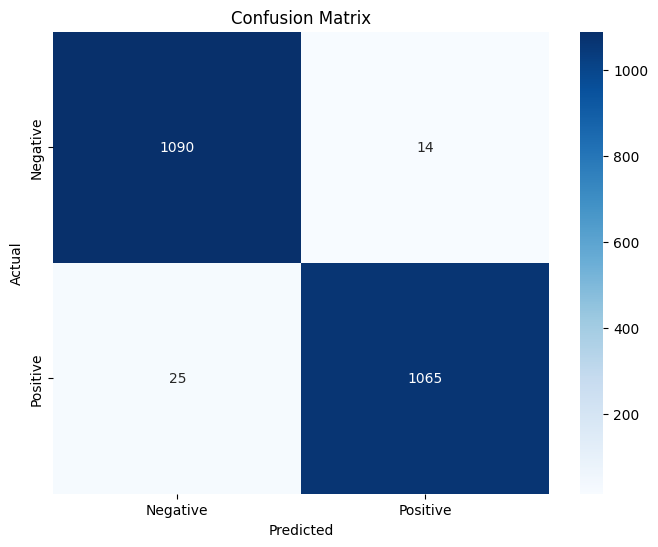

In [12]:
# Plot confusion matrix
from matplotlib import pyplot as plt
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

0.9980683253556707


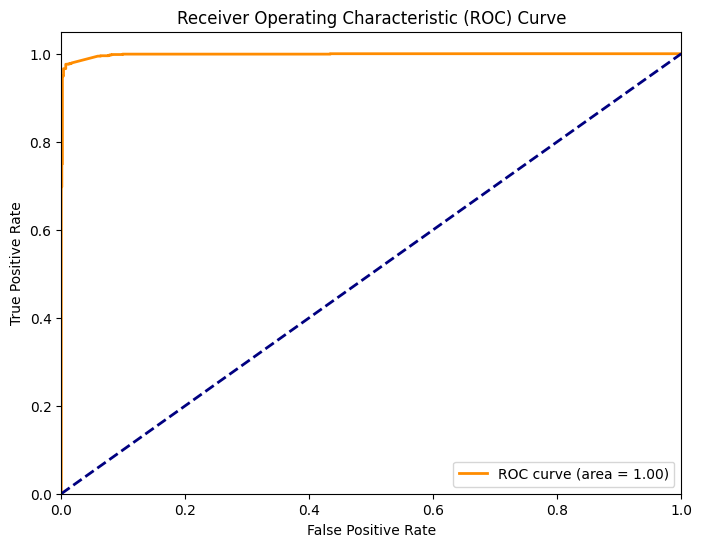

In [14]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(all_labels, all_probs[:, 1])
roc_auc = auc(fpr, tpr)

print(roc_auc)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()